# Code for loading in the datasets and modelling

In [8]:
from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof

## Load in data

Dataset size: 287 
Window size: 15 
Image: (110, 120)
Memory needed: 0.42 GB


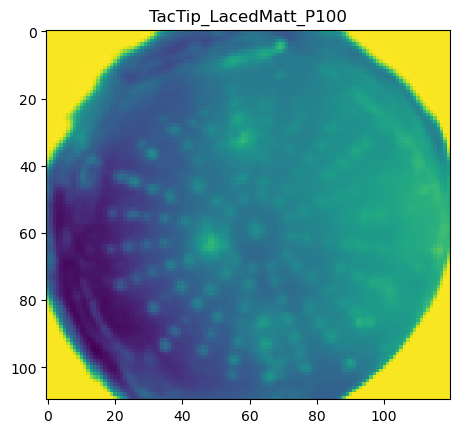

In [189]:
#load the file version
class dataset:
    def __init__(self,pathways,temporal_window,delay=0,compression_dim=1,crop=None):
        self.pathways=pathways
        self.T=temporal_window
        self.X=[]
        self.y=[]
        new_dim=(int(640*compression_dim),int(480*compression_dim))
        self.keys={}
        if type(crop)!=type(None):
            crop_x=abs(crop[0]-crop[1])
            crop_y=abs(crop[2]-crop[3])
        for i,path in enumerate(self.pathways): #loop through paths
            self.keys[i]=path.split("/")[-2]
            files=list_files(path)
            for k in range(0,len(files),5): #loop through files
                file=files[k]
                if ".npz" in file: #is numpy
                    data = np.load(path+"/"+file) #load data
                    for array_name in data:
                        data=data[array_name].reshape(100,480,640,3)
                        window=data[::4][delay:delay+temporal_window]
                        a=np.zeros((len(window),new_dim[1],new_dim[0],))
                        if type(crop)!=type(None):
                            a=np.zeros((len(window),crop_y,crop_x,))
                        if compression_dim<1:
                            for j,frame in enumerate(window):
                                image=cv2.resize(frame,new_dim,interpolation=cv2.INTER_AREA) #resize to new dimentions
                                if type(crop)!=type(None): a[j]=cv2.cvtColor(image[crop[2]:crop[3],crop[0]:crop[1]],cv2.COLOR_BGR2GRAY) #crop out centre
                                else: a[j]=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                                #a[j] = cv2.cvtColor(a[j], cv2.COLOR_BGR2GRAY)
                        window=a.copy()
                        self.X.append(window)
                        self.y.append(i)
                
        self.X=np.array(self.X)
        self.y=np.array(self.y)
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def crop(self,x,x1,y,y1):
        crop_x=abs(x-x1)
        crop_y=abs(y-y1)
        temp=np.zeros((self.X.shape[0],self.X.shape[1],crop_y,crop_x,3))
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                temp[i][j]=self.X[i][j][y:y1,x:x1]
        self.X=temp
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

data=dataset(Folders,20,compression_dim=0.4,delay=10,crop=[60,180,40,150]) #20 steps approximatly 4 seconds
plt.imshow(data.X[0][0].astype(int))
plt.title(data.keys[data.y[0]])
plt.show()
#data.applySobel()
#plt.imshow(data.X[0][0].astype(int))
#plt.title(data.keys[data.y[0]])
#plt.show()

In [197]:
data.applySobel()

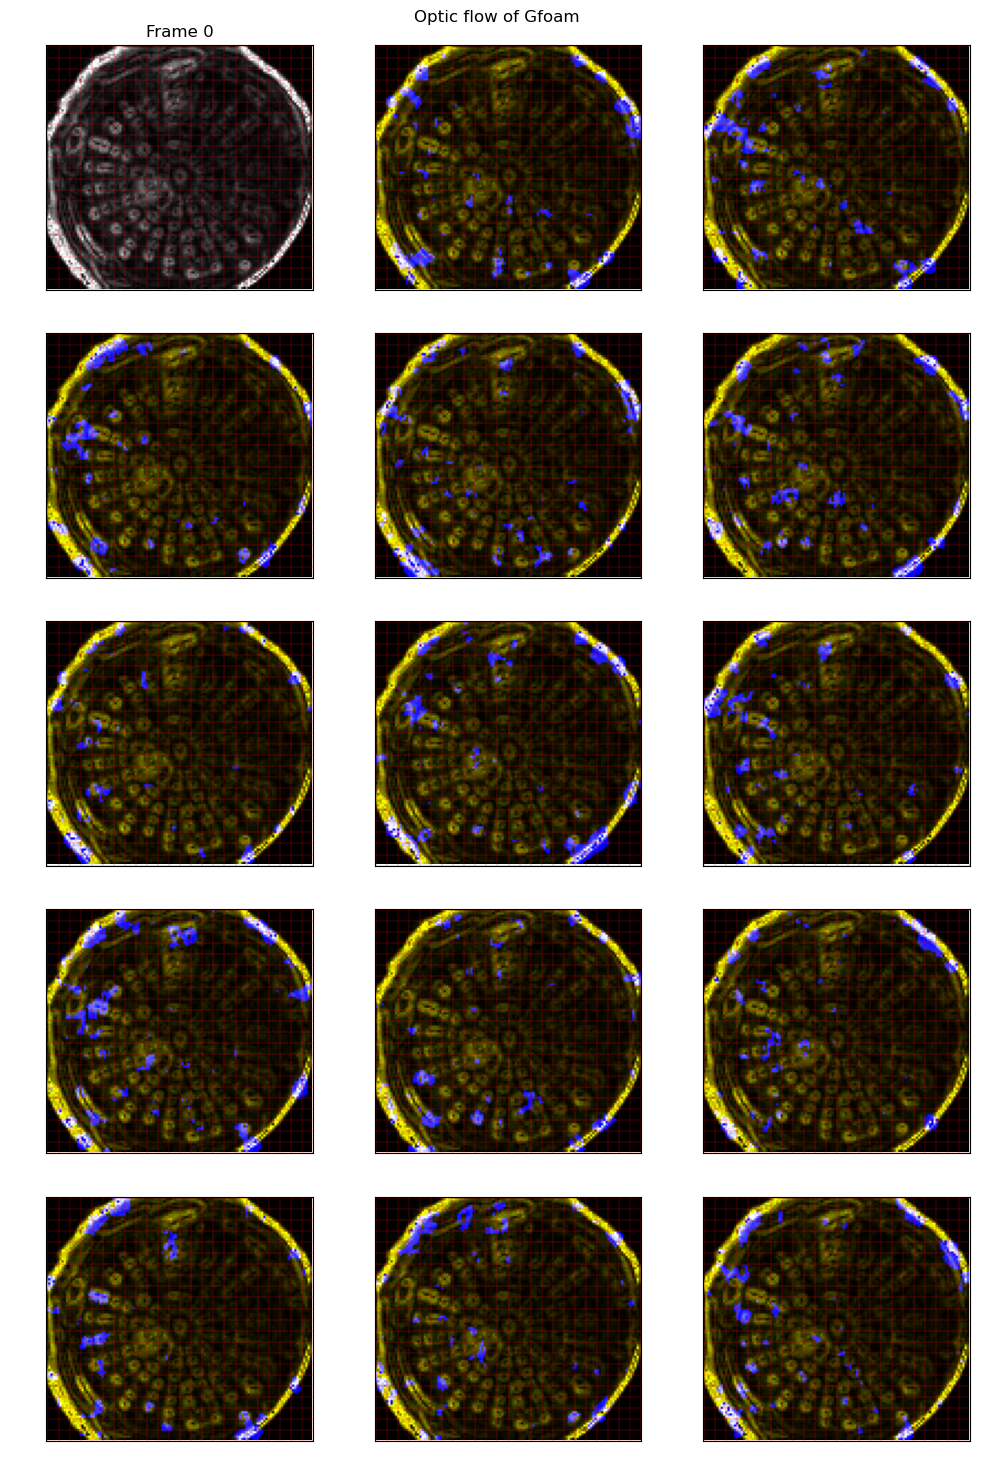

In [253]:
num_images = 15
texture=np.random.randint(0,100)
images = data.X[texture][0:15]

num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()
ax = axes[0]
ax.set_title("Frame "+str(0))
ax.imshow(images[0], cmap='gray')
ax.set_xticks(np.arange(0, images[0].shape[1]+1, 5))
# Set custom ticks for y-axis (every 10 units)
ax.set_yticks(np.arange(0, images[0].shape[0]+1, 5))
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.2)
# Plot each image
kernel=np.array((9,9))
for i in range(1,num_images):
    #n=1
    imageA=images[i-1].astype(np.uint8)
    imageB=images[i].astype(np.uint8)
    frame_diff = cv2.subtract(imageA, imageB)
    #frame_diff=np.stack((frame_diff,) * 3, axis=-1)
    frame_diff = cv2.medianBlur(frame_diff, 1)
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV, 11, 3)
    mask = cv2.medianBlur(mask, 3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    coloured=np.stack((imageA,) * 3, axis=-1)
    coloured[:,:,2]=mask
    coloured[:,:,1]-=mask
    coloured[:,:,0]-=mask
    coloured[coloured>255]=255
    coloured[coloured<0]=0
    ax = axes[i]
    ax.imshow(coloured)
    #ax.axis('off')
    ax.set_xticks(np.arange(0, imageA.shape[1]+1, 5))
    # Set custom ticks for y-axis (every 10 units)
    ax.set_yticks(np.arange(0, imageA.shape[0]+1, 5))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, which='both', axis='both', color='r', linestyle='-', linewidth=0.2)
    

# Remove any empty subplots
for i in range(num_images, num_rows*num_cols):
    fig.delaxes(axes[i])
plt.suptitle("Optic flow of "+str(data.keys[data.y[texture]].split("_")[1]))
plt.tight_layout()
plt.show()

## Look at spread of changes

In [63]:
change=[np.zeros((len(data.X[0]))) for i in range(len(data.keys))]
counter=[0 for i in range(len(data.keys))]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=np.abs(np.sum(framesA-framesB,axis=1))
    change[y]+=difference
    counter[y]+=1

change=(np.array(change).T/np.array(counter)).T
change.shape

(7, 40)

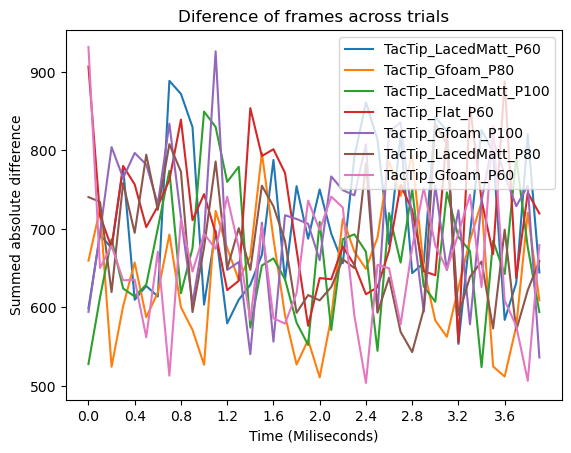

In [67]:
for i in range(len(change)):
    plt.plot(change[i],label=data.keys[i])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across trials")
plt.show()

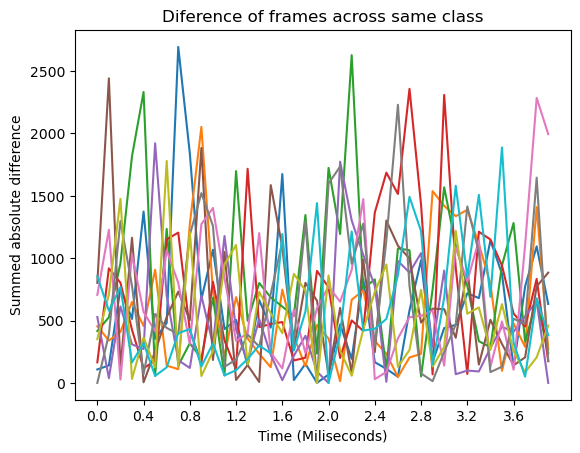

In [69]:
found=0
i=0
while found<10:
    y=data.y[i]
    if y==0:
        framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
        framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        plt.plot(difference)
        found+=1
    i+=1
plt.xticks([i for i in range(0,len(change[0]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[0]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.ylabel("Summed absolute difference")
plt.title("Diference of frames across same class")
plt.show()
    